# DEMO: Two-qubit QAE instance

In this demo, we compress a two-qubit data set such that we have its (lossy) description using one qubit.

We show the state preparation and training circuits below (circuits for both training schemes are shown but in this notebook, we run the "full with reset" method):

<img src="../images/two_qubit_circuits.png" width="500">

We first generate the data set by varying $\phi$ (40 equally-spaced points from $\frac{-\pi}{2}$ to $\frac{\pi}{2}$). Then, a single-parameter circuit is used to find the 2-1-2 map. Looking at the circuit, the minimum should be when $\theta = 0$.


In [1]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.optimize

from pyquil.gates import *
from pyquil import Program

from qcompress.qae_engine import *
from qcompress.utils import *

global pi
pi = np.pi

## QAE Settings

In the cell below, we enter the settings for the QAE.

__NOTE__: Because QCompress was designed to run on the quantum device (as well as the simulator), we need to anticipate nontrival mappings between abstract qubits and physical qubits. The dictionaries `q_in`,  `q_latent`, and `q_refresh` are abstract-to-physical qubit mappings for the input, latent space, and refresh qubits respectively. A cool plug-in/feature to add would be to have an automated "qubit mapper" to determine the optimal or near-optimal abstract-to-physical qubit mappings for a particular QAE instance.

In [2]:
### QAE setup options

# Abstract-to-physical qubit mapping
q_in = {'q0': 0, 'q1': 1} # Input qubits
q_latent = {'q1': 1}      # Latent space qubits
q_refresh = {'q0': 0}     # Refresh qubits

# Training scheme: Full with reset feature (q_refresh = q_in - q_latent)
trash_training = False
reset = True

# Simulator settings
cxn_setting = '9q-generic-qvm'
n_shots = 5000

### Aside: Running on the QPU

To execute the quantum autoencoder on an actual quantum device, the user simply replaces `cxn_setting` to a valid quantum processing unit (QPU) setting. This is also assuming the user has already made reservations on his/her quantum machine image (QMI) to use the QPU. To sign up for an account on Rigetti's Quantum Cloud Services (QCS), click [here](https://www.rigetti.com/qcs).

## Data preparation circuits

To prepare the quantum data, we define the state preparation circuits (and their daggered circuits). In this particular example, we will generate the data by scanning over various values of `phi`. 

In [3]:
def _state_prep_circuit(phi, qubit_indices):
    """
    Returns parametrized state preparation circuit.
    We will vary over phi to generate the data set.
    
    :param phi: (list or numpy.array, required) List or array of data generation parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: State preparation circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(RY(phi[0], qubit_indices[1]))
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    return circuit

def _state_prep_circuit_dag(phi, qubit_indices):
    """
    Returns the daggered version of the state preparation circuit.
    
    :param phi: (list or numpy.array, required) List or array of data generation parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: State un-preparation circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    circuit += Program(RY(-phi[0], qubit_indices[1]))
    return circuit

## Qubit labeling

In the cell below, we produce lists of __ordered__ physical qubit indices involved in the compression and recovery maps of the quantum autoencoder. Depending on the training and reset schemes, we may use different qubits for the compression vs. recovery.

In [4]:
compression_indices = order_qubit_labels(q_in).tolist()

q_out = merge_two_dicts(q_latent, q_refresh)
recovery_indices = order_qubit_labels(q_out).tolist()

if not reset:
    recovery_indices = recovery_indices[::-1]

print("Physical qubit indices for compression : {0}".format(compression_indices))
print("Physical qubit indices for recovery    : {0}".format(recovery_indices))

Physical qubit indices for compression : [0, 1]
Physical qubit indices for recovery    : [0, 1]


For the full training scheme with no resetting feature, this will require the three total qubits. 

The first two qubits (`q0`, `q1`) will be used to encode the quantum data. `q1` will then be used as the latent space qubit, meaning our objective will be to reward the training conditions that "push" the information to the latent space qubit. Then, a refresh qubit, `q2`, is added to recover the original data.

## Data generation

After determining the qubit mapping, we add this physical qubit information to the state preparation circuits and store the "mapped" circuits.

In [5]:
# Lists to store state preparation circuits
list_SP_circuits = []
list_SP_circuits_dag = []

phi_list = np.linspace(-pi/2., pi/2., 40)

for angle in phi_list:

    # Map state prep circuits
    state_prep_circuit = _state_prep_circuit([angle], compression_indices)
    
    # Map daggered state prep circuits
    if reset:
        state_prep_circuit_dag = _state_prep_circuit_dag([angle], compression_indices)
    else:
        state_prep_circuit_dag = _state_prep_circuit_dag([angle], recovery_indices)

    # Store mapped circuits
    list_SP_circuits.append(state_prep_circuit)
    list_SP_circuits_dag.append(state_prep_circuit_dag)

## Training circuit preparation

In this step, we choose a parametrized quantum circuit that will be trained to compress then recover the input data set.

__NOTE__: This is a simple one-parameter training circuit.

In [6]:
def _training_circuit(theta, qubit_indices):
    """
    Returns parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(RY(-theta[0]/2, qubit_indices[0]))
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    return circuit

def _training_circuit_dag(theta, qubit_indices):
    """
    Returns the daggered parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Daggered training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    circuit += Program(RY(theta[0]/2, qubit_indices[0]))
    return circuit

As was done for the state preparation circuits, we also map the training circuits with physical qubits we want to use.

In [7]:
training_circuit = lambda param : _training_circuit(param, compression_indices)

if reset:
    training_circuit_dag = lambda param : _training_circuit_dag(param, compression_indices)
else:
    training_circuit_dag = lambda param : _training_circuit_dag(param, recovery_indices)

## Define the QAE instance

Here, we initialize a QAE instance. This is where the user can decide which optimizer to use, etc. 

For this demo, we use `scipy`'s POWELL optimizer. Because various optimizers have different output variable names, we allow the user to enter a function that parses the optimization output. This function always returns the optimized parameter then its function value (in this order). We show an example of how to use this feature below (see `opt_result_parse` function). The POWELL optimizer returns a list of output values, in which the first and second elements are the optimized parameters and their corresponding function value, respectively.

In [8]:
minimizer = scipy.optimize.fmin_powell
minimizer_args = []
minimizer_kwargs = ({'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 500,
                     'full_output': 1, 'retall': 1})
opt_result_parse = lambda opt_res: ([opt_res[0]], opt_res[1])

In [9]:
qae = quantum_autoencoder(state_prep_circuits=list_SP_circuits,
                          training_circuit=training_circuit,
                          q_in=q_in,
                          q_latent=q_latent,
                          q_refresh=q_refresh,
                          state_prep_circuits_dag=list_SP_circuits_dag,
                          training_circuit_dag=training_circuit_dag,
                          trash_training=trash_training,
                          reset=reset,
                          minimizer=minimizer,
                          minimizer_args=minimizer_args,
                          minimizer_kwargs=minimizer_kwargs,
                          opt_result_parse=opt_result_parse,
                          n_shots=n_shots, 
                          print_interval=1)

After defining the instance, we set up the Forest connection (in this case, a simulator) and split the data set.

In [10]:
qae.setup_forest_cxn(cxn_setting)

In [11]:
qae.train_test_split(train_indices=[1, 31, 16, 7, 20, 23, 9, 17])

In [12]:
print(qae)

QCompress Setting
QAE type: 2-1-2
Data size: 40
Training set size: 8
Training mode: full cost function
  Reset qubits: True
Parametric compilation: False
Forest connection: 9q-generic-qvm
  Connection type: QVM


## Training

The autoencoder is trained in the cell below. The lowest possible mean loss value is -1.000.

In [13]:
%%time
initial_guess = [pi/1.2]

avg_loss_train = qae.train(initial_guess)

Iter    0 Mean Loss: -0.5410250
Iter    1 Mean Loss: -0.5399250
Iter    2 Mean Loss: -0.2900750
Iter    3 Mean Loss: -0.9187000
Iter    4 Mean Loss: -0.0541500
Iter    5 Mean Loss: -0.9133750
Iter    6 Mean Loss: -0.0011250
Iter    7 Mean Loss: -0.7756250
Iter    8 Mean Loss: -0.9012000
Iter    9 Mean Loss: -1.0000000
Iter   10 Mean Loss: -0.9591000
Iter   11 Mean Loss: -1.0000000
Iter   12 Mean Loss: -0.9999250
Iter   13 Mean Loss: -0.5404250
Iter   14 Mean Loss: -0.9999750
Iter   15 Mean Loss: -0.9148000
Iter   16 Mean Loss: -0.7973750
Iter   17 Mean Loss: -1.0000000
Iter   18 Mean Loss: -0.9680000
Iter   19 Mean Loss: -0.9864500
Iter   20 Mean Loss: -1.0000000
Iter   21 Mean Loss: -1.0000000
Iter   22 Mean Loss: -1.0000000
Iter   23 Mean Loss: -1.0000000
Iter   24 Mean Loss: -1.0000000
Iter   25 Mean Loss: -1.0000000
Iter   26 Mean Loss: -1.0000000
Iter   27 Mean Loss: -1.0000000
Iter   28 Mean Loss: -1.0000000
Optimization terminated successfully.
         Current function value: -

### Printing the optimized parameters

In [14]:
print(qae.optimized_params)

[array(0.00046359)]


### Plot training loss

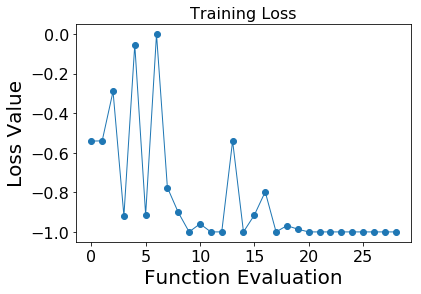

In [15]:
# Visualize loss across function evaluations
fig = plt.figure(figsize=(6, 4))
plt.plot(qae.train_history, 'o-', linewidth=1)
plt.title("Training Loss", fontsize=16)
plt.xlabel("Function Evaluation",fontsize=20)
plt.ylabel("Loss Value", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## Testing

Now test the optimized network against the rest of the data set (i.e. use the optimized parameters to try to compress then recover each test data point).

In [16]:
avg_loss_test = qae.predict()

Iter   29 Mean Loss: -1.0000000
Mean loss for test data: -1.0
